This Notebook aims to combine all necessary steps for each model of the dimensionality reduction methods.


"
Question: Are the following models all DimRed models?

Answer:
1. Partial Least Squares (PLS): 
PLS is a technique that aims to find linear combinations of the original variables that maximize the covariance between the predictors and the response variable. It is commonly used for regression problems but can also be applied for dimensionality reduction.
2. Canonical Partial Least Squares (Canonical PLS): Canonical PLS is an extension of PLS that considers two sets of variables and aims to find linear combinations in each set that maximize the covariance between them. It is often used for multivariate analysis and can be employed for dimensionality reduction.
3. Canonical Correlation Analysis (CCA): 
CCA is a statistical method that analyzes the relationships between two sets of variables and identifies the linear combinations that maximize the correlation between the sets. While its primary use is for studying associations between two variable sets, it can also be used as a dimensionality reduction technique.
4. Principal Component Analysis (PCA): 
PCA is a popular linear dimensionality reduction technique that seeks to find the orthogonal directions (principal components) along which the data has maximum variance. It transforms the original variables into a new set of uncorrelated variables called principal components, allowing for dimensionality reduction while retaining as much information as possible.
5. Independent Component Analysis (ICA): 
ICA is a statistical technique that aims to separate a multivariate signal into additive subcomponents representing statistically independent sources. It assumes that the observed variables are linear mixtures of the independent components and attempts to recover the sources. While ICA is often used for blind source separation, it can also be applied as a dimensionality reduction method.


All these methods provide different approaches to reducing the dimensionality of a dataset, with the goal of capturing the most important information or extracting meaningful patterns while reducing the number of variables or features."

In [2]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mae, mse
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
import copy
from sklearn.decomposition import PCA


import warnings

In [3]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))
# get rid of the LinAlgWarning message
#from numpy.linalg import LinAlgWarning
#warnings.filterwarnings('ignore', category=LinAlgWarning)

In [4]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [5]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

Stored 'cum_returns' (DataFrame)


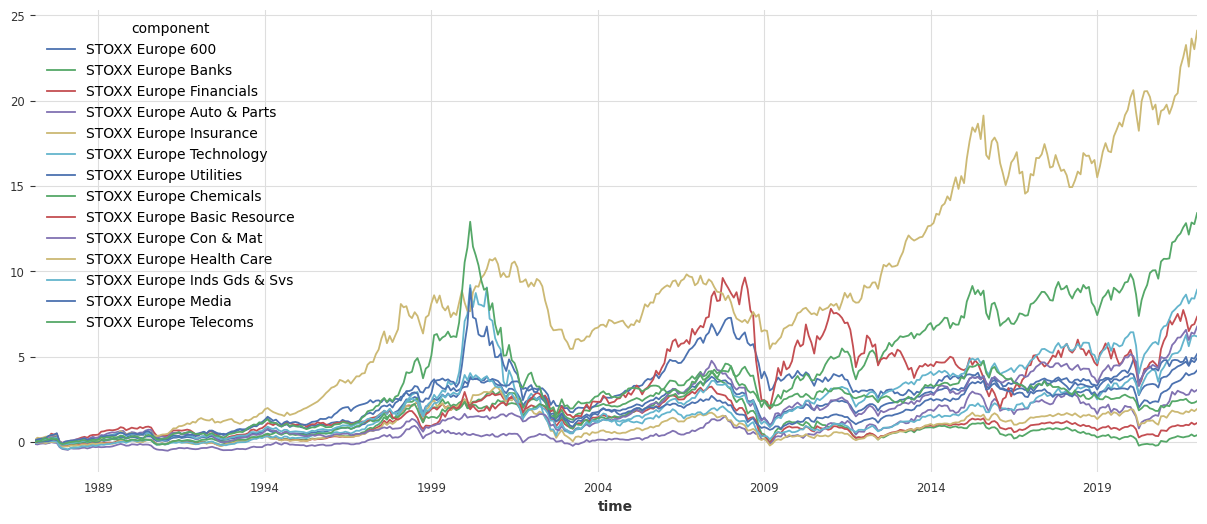

In [6]:
#from io import BytesIO
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns
# store the cum_returns to use it in another notebook
%store cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [7]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [8]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [9]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


### Portfolio based on Historical Average

In [10]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail()

component,equal_weighted,historical_average
time,,
2021-09-01,6.334322,10.565259
2021-10-01,5.926514,9.912039
2021-11-01,6.322933,10.583310
2021-12-01,6.237121,10.402550
2022-01-01,6.544394,10.913366


In [11]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
STOXX Europe Banks             0.033024
STOXX Europe Financials        0.030685
STOXX Europe Auto & Parts      0.021829
STOXX Europe Insurance         0.027747
STOXX Europe Technology        0.050778
STOXX Europe Utilities         0.085845
STOXX Europe Chemicals         0.108597
STOXX Europe Basic Resource    0.099537
STOXX Europe Con & Mat         0.061754
STOXX Europe Health Care       0.258600
STOXX Europe Inds Gds & Svs    0.076979
STOXX Europe Media             0.063096
STOXX Europe Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


In [12]:
def plot_efficient_frontier(mu, S, cum_returns_portfolio, title):
    ef = EfficientFrontier(mu, S)
    ef.add_constraint(lambda x : x[0] == 0.00)
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    ef_min_vol = copy.deepcopy(ef)
    #plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the tangency portfolio with max Sharpe ratio
    ef_max_sharpe.max_sharpe()
    weights_max = ef_max_sharpe.clean_weights()
    ret_max = (cum_returns_portfolio * weights_max).sum(axis=1)
    std_max = ret_max.std()
    ax.scatter(std_max, ret_max.iloc[-1], marker="*", s=100, c="r", label="Max Sharpe")

    # Find the minimum volatility portfolio
    ef_min_vol.min_volatility()
    weights_min = ef_min_vol.clean_weights()
    ret_min = (cum_returns_portfolio * weights_min).sum(axis=1)
    std_min = ret_min.std()
    ax.scatter(std_min, ret_min.iloc[-1], marker="*", s=100, c="g", label="Min Volatility")    
    
    # compute the efficient frontier mathematically while using same optimization objective as the EfficientFrontier class without using pyportfolioopt
    """
    # Compute the efficient frontier
    """

    # save the return and volatility of max sharpe and min vola in two lists to a csv file naming them after mu
    
    
    
    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ S @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    weights_max = pd.DataFrame.from_dict(weights_max, orient='index')
    weights_max.columns = ['Max Sharpe']
    weights_max = weights_max.T
    weights_min = pd.DataFrame.from_dict(weights_min, orient='index')
    weights_min.columns = ['Min Volatility']
    weights_min = weights_min.T
    
    
    # Generate a table with the weights of the max Sharpe ratio portfolio
    weights = pd.concat([weights_max, weights_min])
    # drop the rows with 0 weights in both portfolios
    weights = weights.loc[:, (weights != 0).any(axis=0)]
    # add a column that sums the weights per row
    weights['Sum'] = weights.sum(axis=1)

    # Display the clean table
    print("Weights:\n", weights.to_string(index=True, float_format='{:.2%}'.format))

    # Display the return and volatility of the max Sharpe ratio and min volatility portfolios
    performance = pd.DataFrame({"Return": [ret_max.iloc[-1]/100, ret_min.iloc[-1]/100],
                                "Volatility": [std_max/100, std_min/100]},
                               index=["Max Sharpe", "Min Volatility"])

    # Display the performance table
    print("\nPerformance:\n", performance.to_string(float_format='{:.2%}'.format))

    # Print table as LaTeX
    #print("\nWeights (LaTeX):\n", weights.transpose().to_latex(index=True, float_format='{:.2%}'.format))
    #print("\nPerformance (LaTeX):\n", performance.transpose().to_latex(float_format='{:.2%}'.format))

    # Output
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show();

In [13]:
def generate_pie_chart(weights, title):
    cleaned_weights = {k: v for k, v in weights.items() if v > 1e-5}

    plt.figure(figsize=(10, 5))
    # Generate the pie chart without labels inside the slices
    wedges, _, _ = plt.pie(cleaned_weights.values(), labels=[''] * len(cleaned_weights), autopct='%1.2f%%', startangle=90)

    # Create a legend with the cleaned weights keys
    plt.legend(wedges, cleaned_weights.keys(), loc='upper left')

    # Create a legend with the cleaned weights keys
    plt.legend(wedges, cleaned_weights.keys(), loc='upper left')# Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')
    plt.title(title)
    plt.show();

## Dimensionality Reduction Methods

### PLS Regression

In [14]:
"""hyperparameter_pls = {
    "lags": list(range(317,318,1)),
    'model': [
        sklearn.cross_decomposition.PLSRegression(n_components=n) for n in np.arange(1, 15, 1)
    ]
}"""

'hyperparameter_pls = {\n    "lags": list(range(317,318,1)),\n    \'model\': [\n        sklearn.cross_decomposition.PLSRegression(n_components=n) for n in np.arange(1, 15, 1)\n    ]\n}'

In [15]:
"""pls_regression_tune = RegressionModel(
    lags= hyperparameter_pls['lags'][0],
    model=sklearn.cross_decomposition.PLSRegression(n_components=0)
)"""

"pls_regression_tune = RegressionModel(\n    lags= hyperparameter_pls['lags'][0],\n    model=sklearn.cross_decomposition.PLSRegression(n_components=0)\n)"

In [16]:
"""tuning_pls = pls_regression_tune.gridsearch(
    parameters= hyperparameter_pls,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)"""

'tuning_pls = pls_regression_tune.gridsearch(\n    parameters= hyperparameter_pls,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    metric= mse,\n    n_jobs= -1,\n    verbose= True\n)'

In [17]:
"""# print the best model parameters
best_model, best_params = tuning_pls[0], tuning_pls[1]
best_model.model_params"""

'# print the best model parameters\nbest_model, best_params = tuning_pls[0], tuning_pls[1]\nbest_model.model_params'

In [18]:
# pls regression model with 1 lag
pls_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.PLSRegression(n_components=5))
pls_model_1.fit(train)
pls_forecast_1 = pls_model_1.predict(len(test))

# pls regression model with 316 lags
pls_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.PLSRegression(n_components=1))
pls_model_316.fit(train)
pls_forecast_316 = pls_model_316.predict(len(test))

# pls regression model with 317 lags
pls_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.PLSRegression(n_components=1))
pls_model_317.fit(train)
pls_forecast_317 = pls_model_317.predict(len(test))

# 335 lags was not possible to run

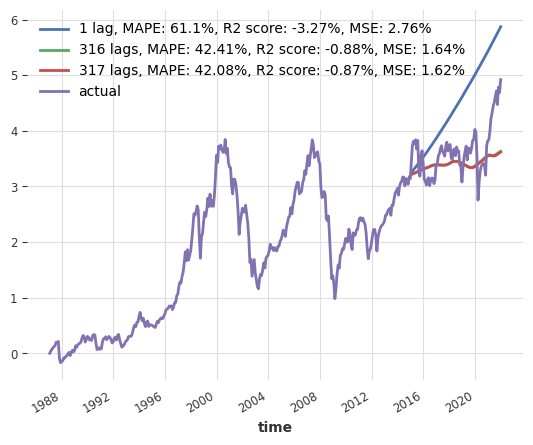

In [19]:
# plot the pls forecast with 1, 316, 317  and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
pls_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, pls_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_1), 2)) + '%')
pls_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, pls_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_316), 2)) + '%')
pls_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, pls_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, pls_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, pls_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [20]:
# first pls regression model with 1 lag
hf1_pls_regression = pls_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# second pls regression model with 316 lags
hf2_pls_regression = pls_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# third pls regression model with 317 lags
#hf3_pls_regression = pls_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

`start` value `0.6` corresponding to timestamp `2008-01-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

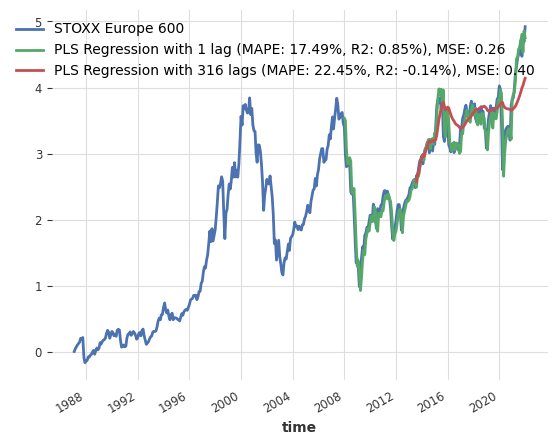

In [21]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_pls_regression, cum_returns), r2_score(hf1_pls_regression, cum_returns), mse(hf1_pls_regression, cum_returns)))
hf2_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_pls_regression, cum_returns), r2_score(hf2_pls_regression, cum_returns), mse(hf2_pls_regression, cum_returns)))
#hf3_pls_regression['STOXX Europe 600'].plot(label='PLS Regression with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_pls_regression, cum_returns), r2_score(hf3_pls_regression, cum_returns), mse(hf3_pls_regression, cum_returns)))

#### Portfolio

In [22]:
# change the type of the pls forecast to pandas dataframe
pls_forecast_1 = pls_forecast_1.pd_dataframe()
pls_forecast_316 = pls_forecast_316.pd_dataframe()

In [23]:
# use the pyportfolioopt library to compute the optimal portfolio 

# perform mean-variance optimization with the linear regression forecast
mu_pls_regression_1 = expected_returns.mean_historical_return(pls_forecast_1)
S_pls_regression_1 = risk_models.sample_cov(pls_forecast_1)

mu_pls_regression_316 = expected_returns.mean_historical_return(pls_forecast_316)
S_pls_regression_316 = risk_models.sample_cov(pls_forecast_316)

In [24]:
# optimize for maximal Sharpe ratio
ef_pls_regression_1 = EfficientFrontier(mu_pls_regression_1, S_pls_regression_1)
weights_pls_1 = ef_pls_regression_1.max_sharpe()

ef_pls_regression_316 = EfficientFrontier(mu_pls_regression_316, S_pls_regression_316)
weights_pls_316 = ef_pls_regression_316.max_sharpe()

In [25]:
# print the weights in a table and round them to 3 decimals and add their sum
print('Weights for PLS regression with 1 lag: ' + str(np.round(pd.Series(weights_pls_1), 3)))
print('Weights for PLS regression with 316 lags: ' + str(np.round(pd.Series(weights_pls_316), 3)))

Weights for PLS regression with 1 lag: STOXX Europe 600               0.050
STOXX Europe Banks            -0.000
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.155
STOXX Europe Insurance         0.025
STOXX Europe Technology        0.057
STOXX Europe Utilities         0.139
STOXX Europe Chemicals         0.040
STOXX Europe Basic Resource    0.159
STOXX Europe Con & Mat         0.059
STOXX Europe Health Care       0.046
STOXX Europe Inds Gds & Svs    0.051
STOXX Europe Media             0.072
STOXX Europe Telecoms          0.148
dtype: float64
Weights for PLS regression with 316 lags: STOXX Europe 600              -0.0
STOXX Europe Banks            -0.0
STOXX Europe Financials        0.0
STOXX Europe Auto & Parts      0.0
STOXX Europe Insurance         1.0
STOXX Europe Technology        0.0
STOXX Europe Utilities         0.0
STOXX Europe Chemicals        -0.0
STOXX Europe Basic Resource   -0.0
STOXX Europe Con & Mat         0.0
STOXX Europe Health Care       0.0
S

In [26]:
# compute the returns of the pls portfolio
pls_returns_1 = (cum_returns_portfolio * weights_pls_1).sum(axis=1)
pls_returns_316 = (cum_returns_portfolio * weights_pls_316).sum(axis=1)

# add portfolio returns to the dataframe
portfolio_returns['pls_regression_1'] = pls_returns_1
portfolio_returns['pls_regression_316'] = pls_returns_316

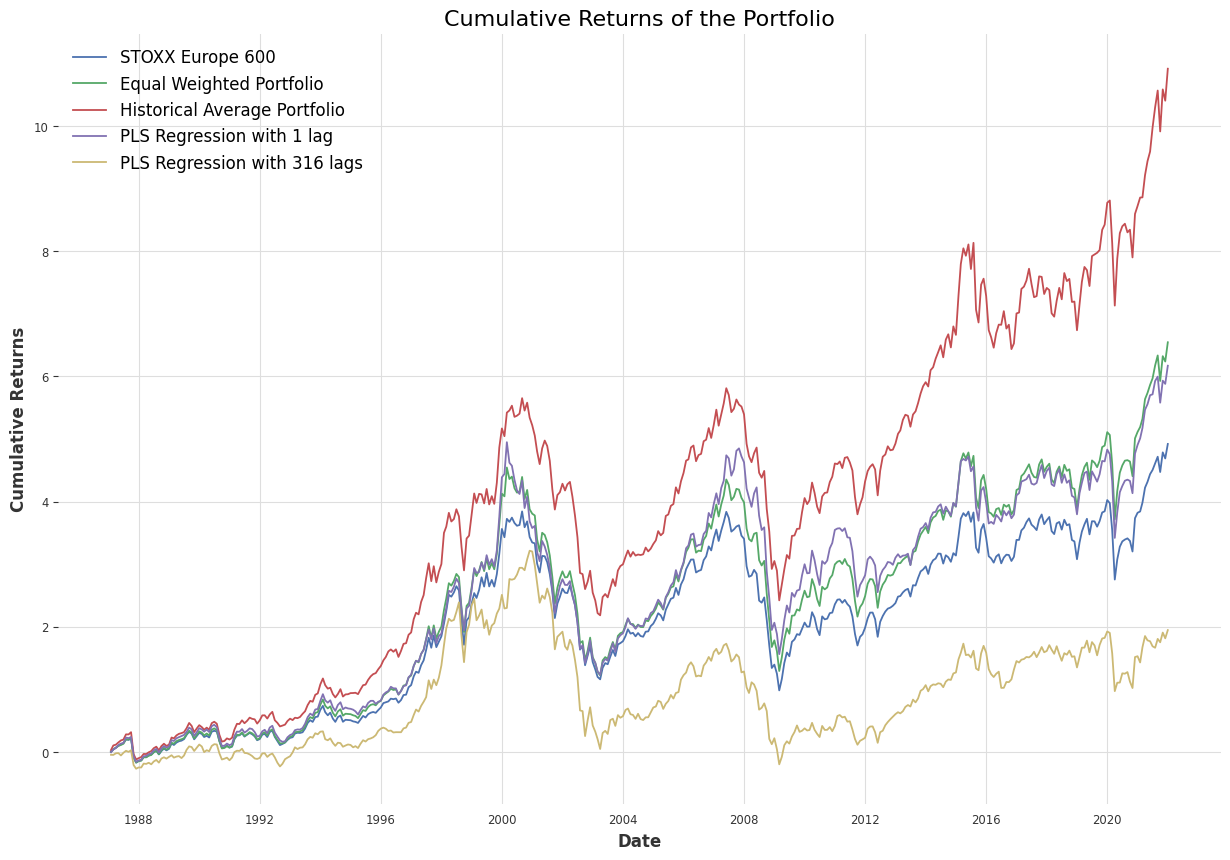

In [27]:
# plot the cumulative returns of the portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['pls_regression_1'], label='PLS Regression with 1 lag')
plt.plot(portfolio_returns['pls_regression_316'], label='PLS Regression with 316 lags')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Cumulative Returns of the Portfolio', fontsize=16)
plt.show();

In [28]:
# show the last value of each portfolio in percent and round to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the pls regression portfolio with 1 lag: ' + str(round(portfolio_returns['pls_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the pls regression portfolio with 316 lags: ' + str(round(portfolio_returns['pls_regression_316'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the pls regression portfolio with 1 lag: 6.17%
Last value of the pls regression portfolio with 316 lags: 1.95%


#### Plots Portfolio Analysis

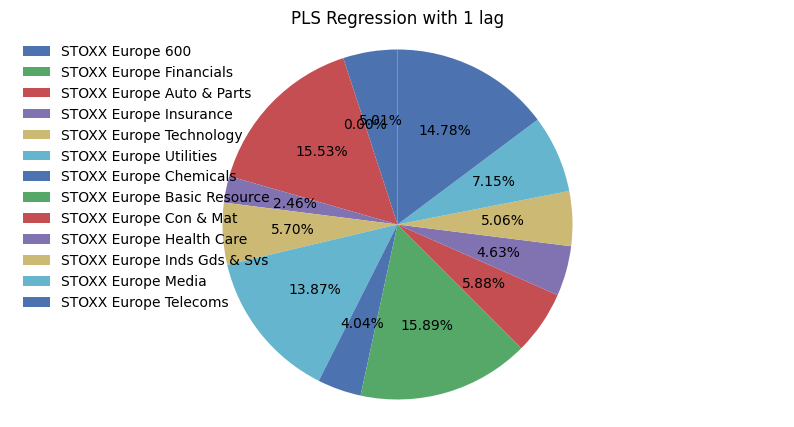

In [29]:
generate_pie_chart(weights_pls_1, 'PLS Regression with 1 lag')

Weights:
                 STOXX Europe Chemicals  STOXX Europe Basic Resource     Sum
Max Sharpe                      94.91%                        5.09% 100.00%
Min Volatility                  94.81%                        5.19% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      13.11%       3.29%
Min Volatility  13.10%       3.28%


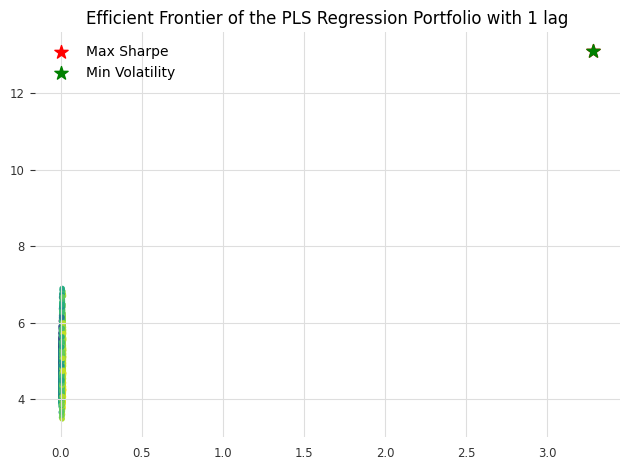

In [30]:
plot_efficient_frontier(mu_pls_regression_1, S_pls_regression_1, cum_returns_portfolio, 'Efficient Frontier of the PLS Regression Portfolio with 1 lag')

### PLS Canonical

In [31]:
"""hyperparameter_canonical = {
    "lags": list(range(316,317,1)),
    'model': [
        sklearn.cross_decomposition.PLSCanonical(n_components=beta) for beta in np.arange(1, 15,1)
    ]
}"""

'hyperparameter_canonical = {\n    "lags": list(range(316,317,1)),\n    \'model\': [\n        sklearn.cross_decomposition.PLSCanonical(n_components=beta) for beta in np.arange(1, 15,1)\n    ]\n}'

In [32]:
"""# pls canonical regression model
pls_canonical_tune = RegressionModel(
    lags=hyperparameter_canonical['lags'][0], 
    model= sklearn.cross_decomposition.PLSCanonical(n_components=0)
    )"""

"# pls canonical regression model\npls_canonical_tune = RegressionModel(\n    lags=hyperparameter_canonical['lags'][0], \n    model= sklearn.cross_decomposition.PLSCanonical(n_components=0)\n    )"

In [33]:
"""tuning_canonical = pls_canonical_tune.gridsearch(
    parameters= hyperparameter_canonical,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)"""

'tuning_canonical = pls_canonical_tune.gridsearch(\n    parameters= hyperparameter_canonical,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    metric= mse,\n    n_jobs= -1,\n    verbose= True\n)'

In [34]:
"""best_model, best_params = tuning_canonical[0], tuning_canonical[1]
best_model.model_params"""

'best_model, best_params = tuning_canonical[0], tuning_canonical[1]\nbest_model.model_params'

In [35]:
# canonical pls regression model with 1 lag
canonical_pls_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.PLSCanonical(n_components=10))
canonical_pls_model_1.fit(train)
canonical_pls_forecast_1 = canonical_pls_model_1.predict(len(test))

# canonical pls regression model with 316 lags
canonical_pls_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.PLSCanonical(n_components=2))
canonical_pls_model_316.fit(train)
canonical_pls_forecast_316 = canonical_pls_model_316.predict(len(test))

# canonical pls regression model with 317 lags
canonical_pls_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.PLSCanonical(n_components=14))
canonical_pls_model_317.fit(train)
canonical_pls_forecast_317 = canonical_pls_model_317.predict(len(test))

# canonical pls regression model with 335 lags
#canonical_pls_forecast_335 = RegressionModel(lags=335, model=sklearn.cross_decomposition.PLSCanonical(n_components=1))

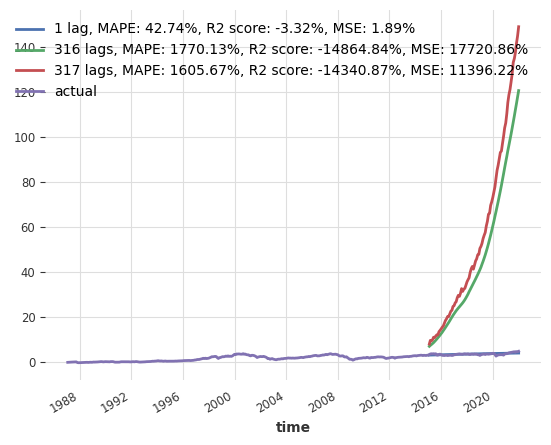

In [36]:
# plot the canonical pls forecast with 1, 316, 317 and 335 and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
canonical_pls_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, canonical_pls_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_1), 2)) + '%')
canonical_pls_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_316), 2)) + '%')
canonical_pls_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_317), 2)) + '%')
#canonical_pls_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, canonical_pls_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, canonical_pls_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, canonical_pls_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [37]:
# first canonical pls model with 1 lag
hf1_canonical_pls = canonical_pls_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second canonical pls model with 316 lags
hf2_canonical_pls = canonical_pls_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

`start` value `0.7` corresponding to timestamp `2011-07-01 00:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2013-08-01 00:00:00. To hide these warnings, set `show_warnings=False`.


  0%|          | 0/102 [00:00<?, ?it/s]

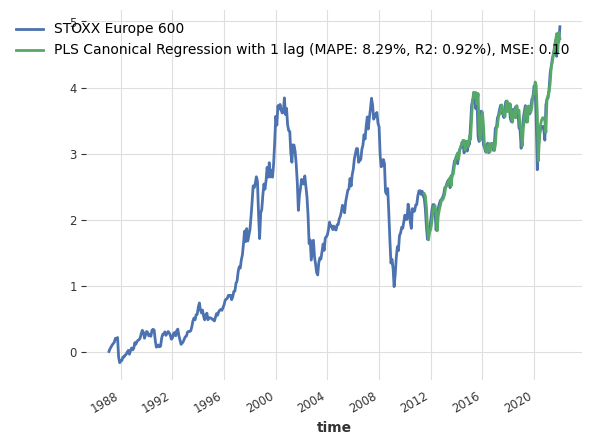

In [38]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_canonical_pls['STOXX Europe 600'].plot(label='PLS Canonical Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_canonical_pls, cum_returns), r2_score(hf1_canonical_pls, cum_returns), mse(hf1_canonical_pls, cum_returns)))
#hf2_canonical_pls['STOXX Europe 600'].plot(label='PLS Canonical Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_canonical_pls, cum_returns), r2_score(hf2_canonical_pls, cum_returns), mse(hf2_canonical_pls, cum_returns)))


#### Portfolio

In [39]:
# change type of canonical pls forecast to pandas dataframe
canonical_pls_forecast_1 = canonical_pls_forecast_1.pd_dataframe()

In [40]:
# perform mean-variance optimization on the canonical pls forecast
mu_canonical_pls_1 = expected_returns.mean_historical_return(canonical_pls_forecast_1)
S_canonical_pls_1 = risk_models.sample_cov(canonical_pls_forecast_1)

In [41]:
# optimize for maximal Sharpe ratio
ef_canonical_pls_1 = EfficientFrontier(mu_canonical_pls_1, S_canonical_pls_1)
ef_canonical_pls_1.add_constraint(lambda x : x[0] == 0.00)
weights_canonical_pls_1 = ef_canonical_pls_1.max_sharpe()

In [42]:
# print the weights in a table and round them to 4 decimals
print('Weights for PLS Canonical regression with 1 lag: ' + str(np.round(pd.Series(weights_canonical_pls_1), 3)))


Weights for PLS Canonical regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.005
STOXX Europe Financials        0.000
STOXX Europe Auto & Parts      0.187
STOXX Europe Insurance         0.000
STOXX Europe Technology        0.003
STOXX Europe Utilities         0.364
STOXX Europe Chemicals         0.079
STOXX Europe Basic Resource    0.011
STOXX Europe Con & Mat         0.000
STOXX Europe Health Care       0.181
STOXX Europe Inds Gds & Svs    0.160
STOXX Europe Media             0.010
STOXX Europe Telecoms         -0.000
dtype: float64


In [43]:
# compute the returns of the canonical pls portfolio
canonical_returns_1 = (cum_returns_portfolio * weights_canonical_pls_1).sum(axis=1)

# add the canonical pls portfolio to the dataframe
portfolio_returns['canonical_pls_1'] = canonical_returns_1

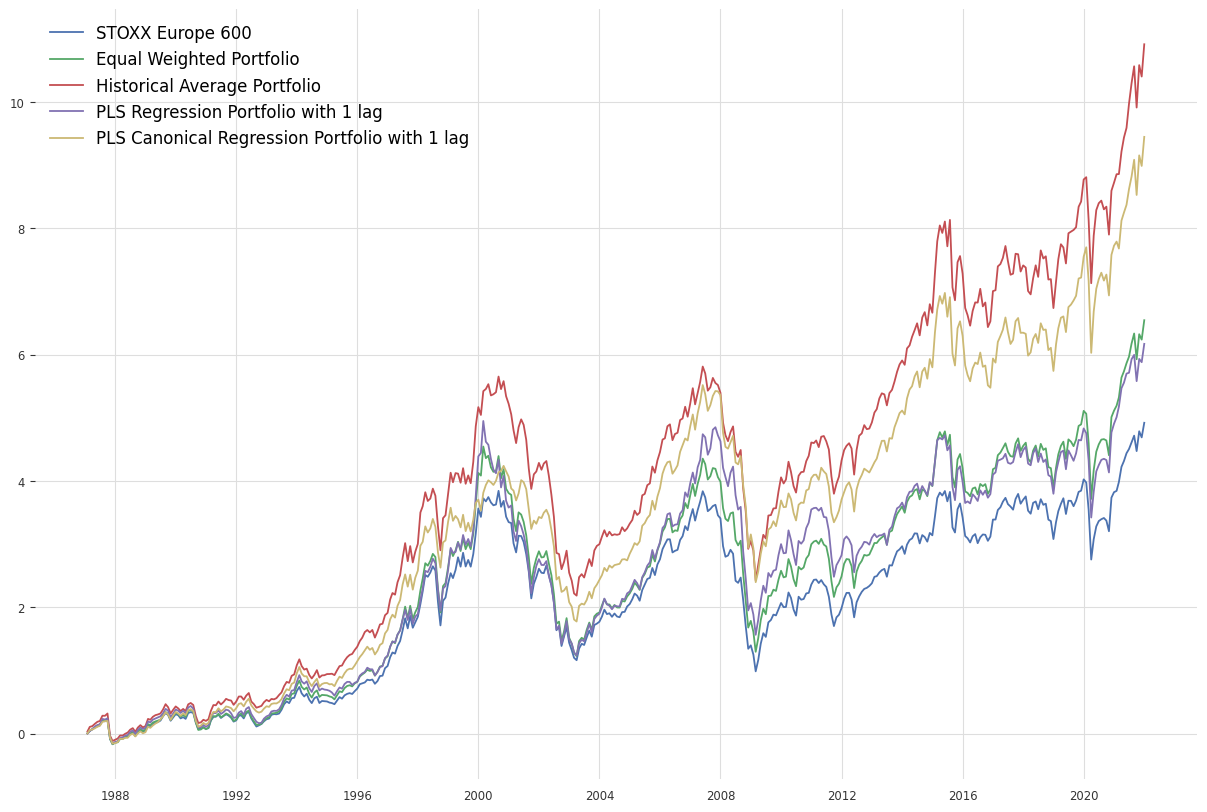

In [44]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['pls_regression_1'], label='PLS Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['canonical_pls_1'], label='PLS Canonical Regression Portfolio with 1 lag')
plt.legend(loc='upper left', fontsize=12)
plt.show();

In [45]:
# show the last value of each portfolio in percent and round to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the pls regression portfolio with 1 lag: ' + str(round(portfolio_returns['pls_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the pls canonical regression portfolio with 1 lag: ' + str(round(portfolio_returns['canonical_pls_1'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the pls regression portfolio with 1 lag: 6.17%
Last value of the pls canonical regression portfolio with 1 lag: 9.45%


#### Plots Portfolio Analysis

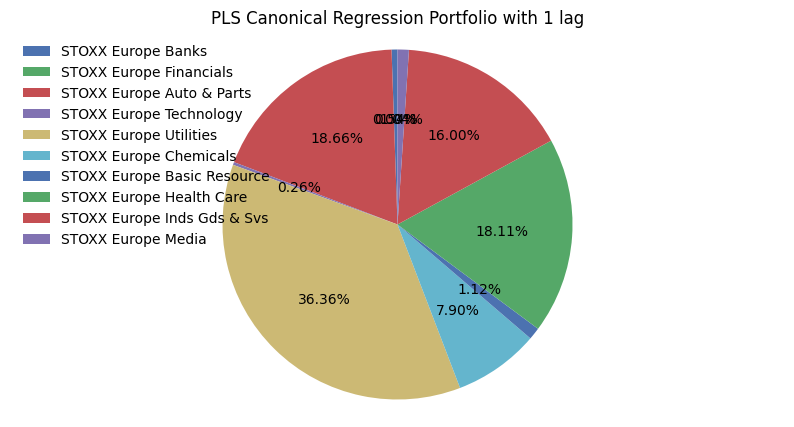

In [46]:
generate_pie_chart(weights_canonical_pls_1, 'PLS Canonical Regression Portfolio with 1 lag')

Weights:
                 STOXX Europe Banks  STOXX Europe Auto & Parts  STOXX Europe Technology  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Basic Resource  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Inds Gds & Svs  STOXX Europe Media  STOXX Europe Telecoms     Sum
Max Sharpe                   0.54%                     18.66%                    0.26%                  36.36%                   7.90%                        1.12%                   0.00%                    18.11%                       16.00%               1.04%                  0.00% 100.00%
Min Volatility               0.56%                      9.54%                    0.23%                  29.30%                  20.40%                        1.07%                   0.27%                    15.92%                       20.44%               1.94%                  0.31% 100.00%

Performance:
                 Return  Volatility
Max Sharpe       9.45%       2.32%
Min Volatility  10.41% 

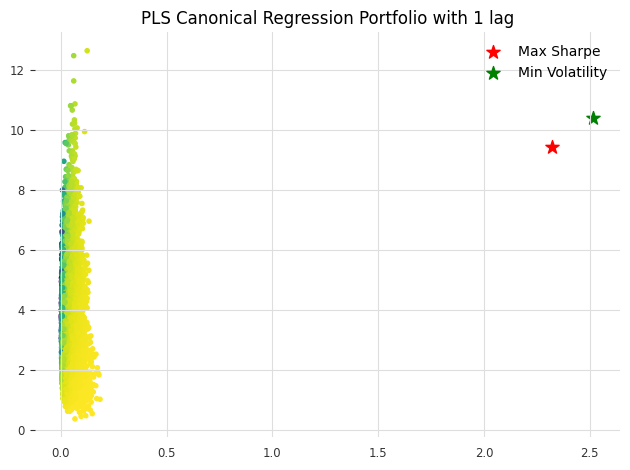

In [47]:
plot_efficient_frontier(mu_canonical_pls_1, S_canonical_pls_1, cum_returns_portfolio, 'PLS Canonical Regression Portfolio with 1 lag')

### CCA

In [48]:
"""hyperparameter_cca = {
    "lags": list(range(1,2, 1)),
    'model': [
        sklearn.cross_decomposition.CCA(n_components=beta) for beta in np.arange(1, 15,1)
    ]
}"""

'hyperparameter_cca = {\n    "lags": list(range(1,2, 1)),\n    \'model\': [\n        sklearn.cross_decomposition.CCA(n_components=beta) for beta in np.arange(1, 15,1)\n    ]\n}'

In [49]:
"""cca_tune = RegressionModel(
    lags= hyperparameter_cca['lags'][0],
    model=sklearn.cross_decomposition.CCA(n_components=0)
)"""

"cca_tune = RegressionModel(\n    lags= hyperparameter_cca['lags'][0],\n    model=sklearn.cross_decomposition.CCA(n_components=0)\n)"

In [50]:
"""tuning_cca = cca_tune.gridsearch(
    parameters= hyperparameter_cca,
    series= train,
    val_series= test,
    start= 0.3,
    #metric= mape,
    n_jobs= -1,
    verbose= True
)"""

'tuning_cca = cca_tune.gridsearch(\n    parameters= hyperparameter_cca,\n    series= train,\n    val_series= test,\n    start= 0.3,\n    #metric= mape,\n    n_jobs= -1,\n    verbose= True\n)'

In [51]:
"""# print the best model parameters
best_model, best_params = tuning_cca[0], tuning_cca[1]
best_model.model_params"""

'# print the best model parameters\nbest_model, best_params = tuning_cca[0], tuning_cca[1]\nbest_model.model_params'

In [52]:
# cca regression model with 1 lag
cca_model_1 = RegressionModel(lags=1, model=sklearn.cross_decomposition.CCA(n_components=14))
cca_model_1.fit(train)
cca_forecast_1 = cca_model_1.predict(len(test))

# cca regression model with 316 lags
cca_model_316 = RegressionModel(lags=316, model=sklearn.cross_decomposition.CCA(n_components=1))
cca_model_316.fit(train)
cca_forecast_316 = cca_model_316.predict(len(test))

# cca regression model with 317 lags
cca_model_317 = RegressionModel(lags=317, model=sklearn.cross_decomposition.CCA(n_components=1))
cca_model_317.fit(train)
cca_forecast_317 = cca_model_317.predict(len(test))

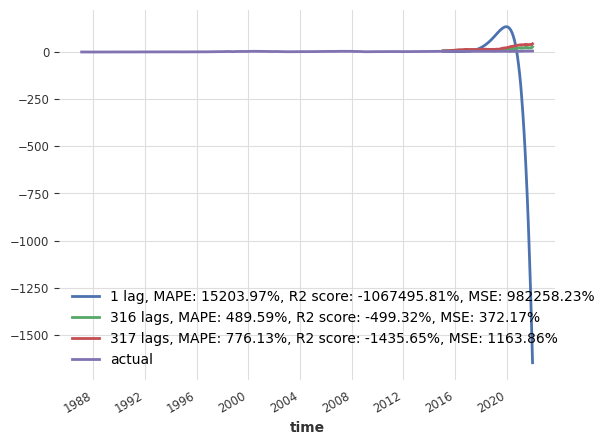

In [53]:
# plot the cca forecast with 1, 316 and 317 and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
cca_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, cca_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_1), 2)) + '%')
cca_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, cca_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_316), 2)) + '%')
cca_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, cca_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, cca_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, cca_forecast_317), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [54]:
# first cca model with 1 lag
hf1_cca = cca_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second cca model with 316 lags
#hf2_cca = cca_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

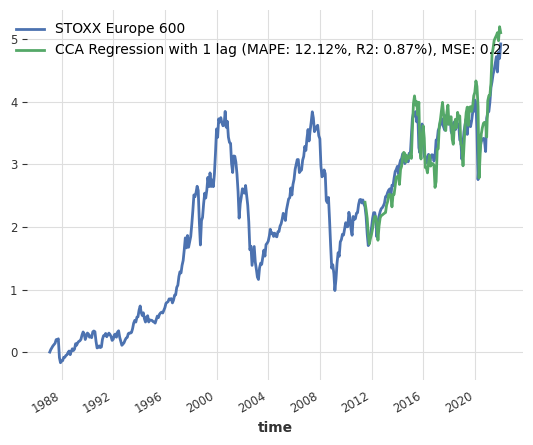

In [55]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_cca['STOXX Europe 600'].plot(label='CCA Regression with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_cca, cum_returns), r2_score(hf1_cca, cum_returns), mse(hf1_cca, cum_returns)))
#
#hf2_cca['STOXX Europe 600'].plot(label='CCA Regression with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_cca, cum_returns), r2_score(hf2_cca, cum_returns), mse(hf2_cca, cum_returns)))


#### Portfolio

In [56]:
# change the type of the cca forecast to a dataframe
cca_forecast_1 = cca_forecast_1.pd_dataframe()

In [57]:
# perform mean-variance optimization on the cca forecast
mu_cca_1 = expected_returns.mean_historical_return(cca_forecast_1)
S_cca_1 = risk_models.sample_cov(cca_forecast_1)

In [58]:
# fill nan values with 0
mu_cca_1 = mu_cca_1.fillna(0)
S_cca_1 = S_cca_1.fillna(0)

In [59]:
# optimize for maximal Sharpe ratio
ef_cca_1 = EfficientFrontier(mu_cca_1, S_cca_1)
ef_cca_1.add_constraint(lambda x : x[0] == 0.00)
weights_cca_1 = ef_cca_1.max_sharpe()

In [60]:
# print the weights in a table and round them to 4 decimals
print('Weights for CCA regression with 1 lag: ' + str(np.round(pd.Series(weights_cca_1), 3)))

Weights for CCA regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.003
STOXX Europe Financials        0.016
STOXX Europe Auto & Parts      0.064
STOXX Europe Insurance         0.009
STOXX Europe Technology        0.070
STOXX Europe Utilities         0.014
STOXX Europe Chemicals        -0.015
STOXX Europe Basic Resource   -0.016
STOXX Europe Con & Mat        -0.013
STOXX Europe Health Care       0.548
STOXX Europe Inds Gds & Svs    0.075
STOXX Europe Media             0.192
STOXX Europe Telecoms          0.054
dtype: float64


In [61]:
# compute the returns of the cca regression
cca_returns_1 = (cum_returns_portfolio * weights_cca_1).sum(axis=1)

# add the cca returns to the portfolio returns
portfolio_returns['cca_regression_1'] = cca_returns_1

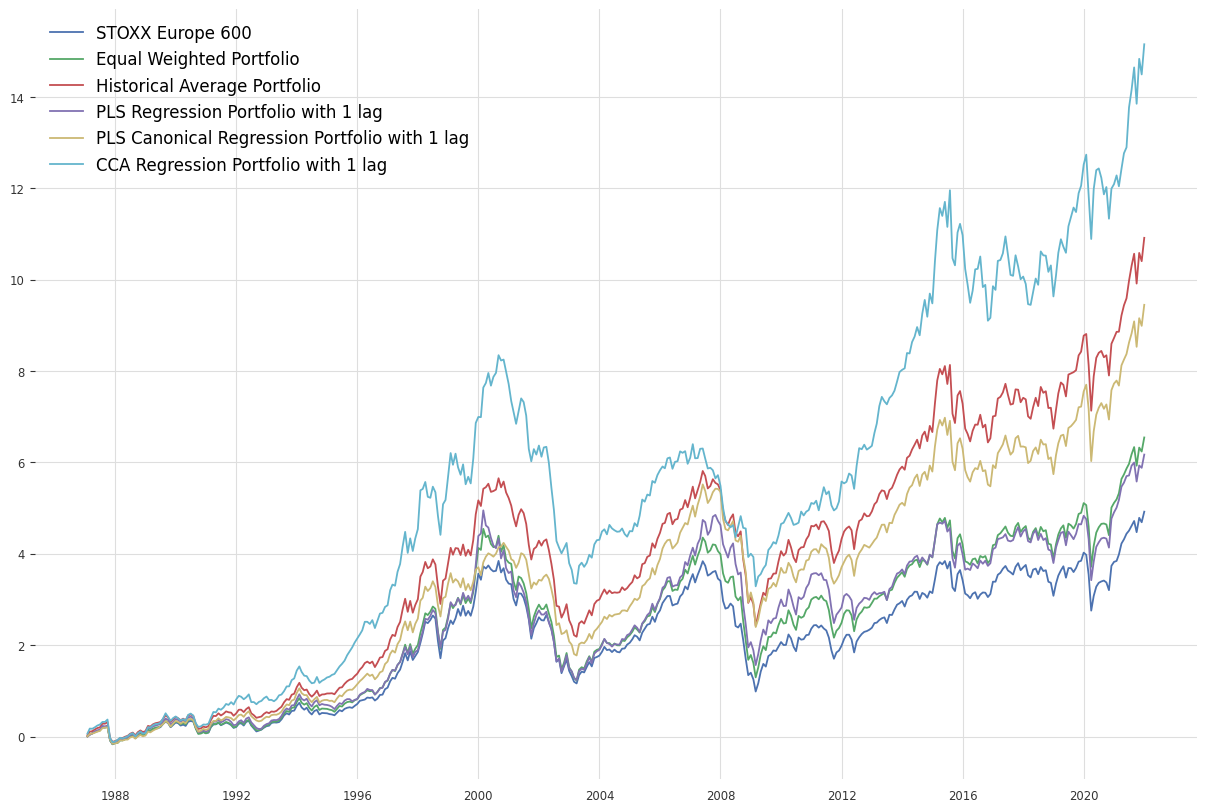

In [62]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['pls_regression_1'], label='PLS Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['canonical_pls_1'], label='PLS Canonical Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['cca_regression_1'], label='CCA Regression Portfolio with 1 lag')
plt.legend(loc='upper left', fontsize=12)
plt.show();

In [63]:
# show the last value of each portfolio in percent and round to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Last value of the pls regression portfolio with 1 lag: ' + str(round(portfolio_returns['pls_regression_1'].iloc[-1], 2)) + '%')
print('Last value of the pls canonical regression portfolio with 1 lag: ' + str(round(portfolio_returns['canonical_pls_1'].iloc[-1], 2)) + '%')
print('Last value of the cca regression portfolio with 1 lag: ' + str(round(portfolio_returns['cca_regression_1'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
Last value of the pls regression portfolio with 1 lag: 6.17%
Last value of the pls canonical regression portfolio with 1 lag: 9.45%
Last value of the cca regression portfolio with 1 lag: 15.15%


#### Plots Portfolio Analysis

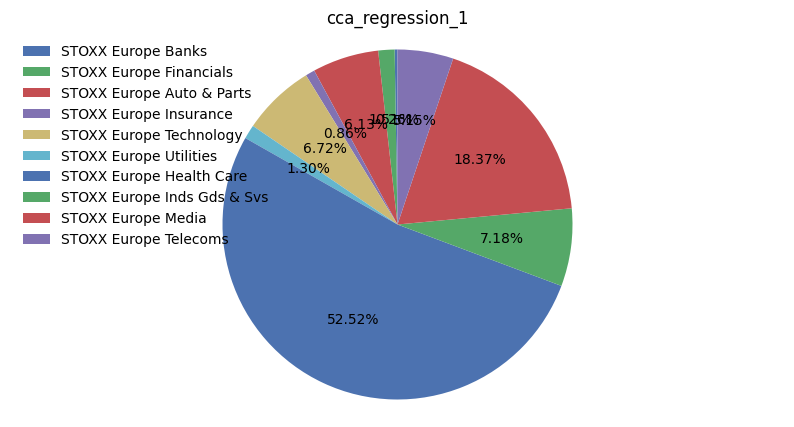

In [64]:
generate_pie_chart(weights_cca_1, 'cca_regression_1')

Weights:
                 STOXX Europe Banks  STOXX Europe Financials  STOXX Europe Auto & Parts  STOXX Europe Insurance  STOXX Europe Technology  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Basic Resource  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Inds Gds & Svs  STOXX Europe Media  STOXX Europe Telecoms     Sum
Max Sharpe                   0.27%                    1.57%                      6.40%                   0.90%                    7.02%                   1.36%                  -1.52%                       -1.57%                  -1.33%                    54.84%                        7.50%              19.18%                  5.38% 100.00%
Min Volatility              16.00%                   18.12%                     16.39%                   1.62%                    2.40%                   0.93%                   0.00%                        0.00%                   5.76%                    14.78%                       17.74%             

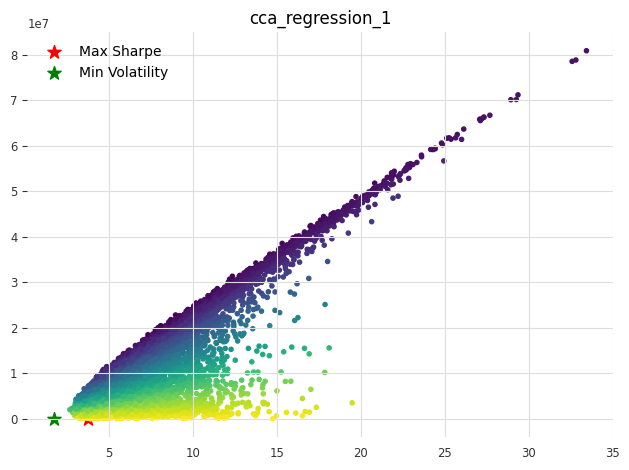

In [65]:
plot_efficient_frontier(mu_cca_1, S_cca_1, cum_returns_portfolio, 'cca_regression_1')

### Check further models

1. Principal component analysis (PCA):

Question: Can you generally use the sklearn.decomposition.PCA for regression tasks such as stock prediction?

Answer: No, the sklearn.decomposition.PCA method is not directly designed for regression tasks like stock prediction. PCA (Principal Component Analysis) is primarily used for dimensionality reduction and feature extraction, rather than regression modeling.

PCA is commonly used to reduce the dimensionality of a dataset by identifying the most important features, known as principal components. It does this by transforming the original features into a new set of uncorrelated variables called principal components. These components capture the maximum amount of variance in the data.


2. Independent component analysis (ICA):

Question: Can you generally use the from sklearn.decomposition import FastICA for regression tasks such as stock prediction?

Answer: No, the FastICA algorithm from the sklearn.decomposition module in scikit-learn is primarily designed for Independent Component Analysis (ICA) and blind source separation tasks, rather than regression tasks such as stock price prediction.

ICA is a dimensionality reduction technique that aims to separate a multivariate signal into additive subcomponents, assuming that the subcomponents are statistically independent and non-Gaussian. It is commonly used for signal processing applications, such as audio and image processing, rather than regression problems.

# Outcome Shrinkage Portfolio Building

First generate a graph showing all models compared to their benchmarks & then create a table showing the numerical results.

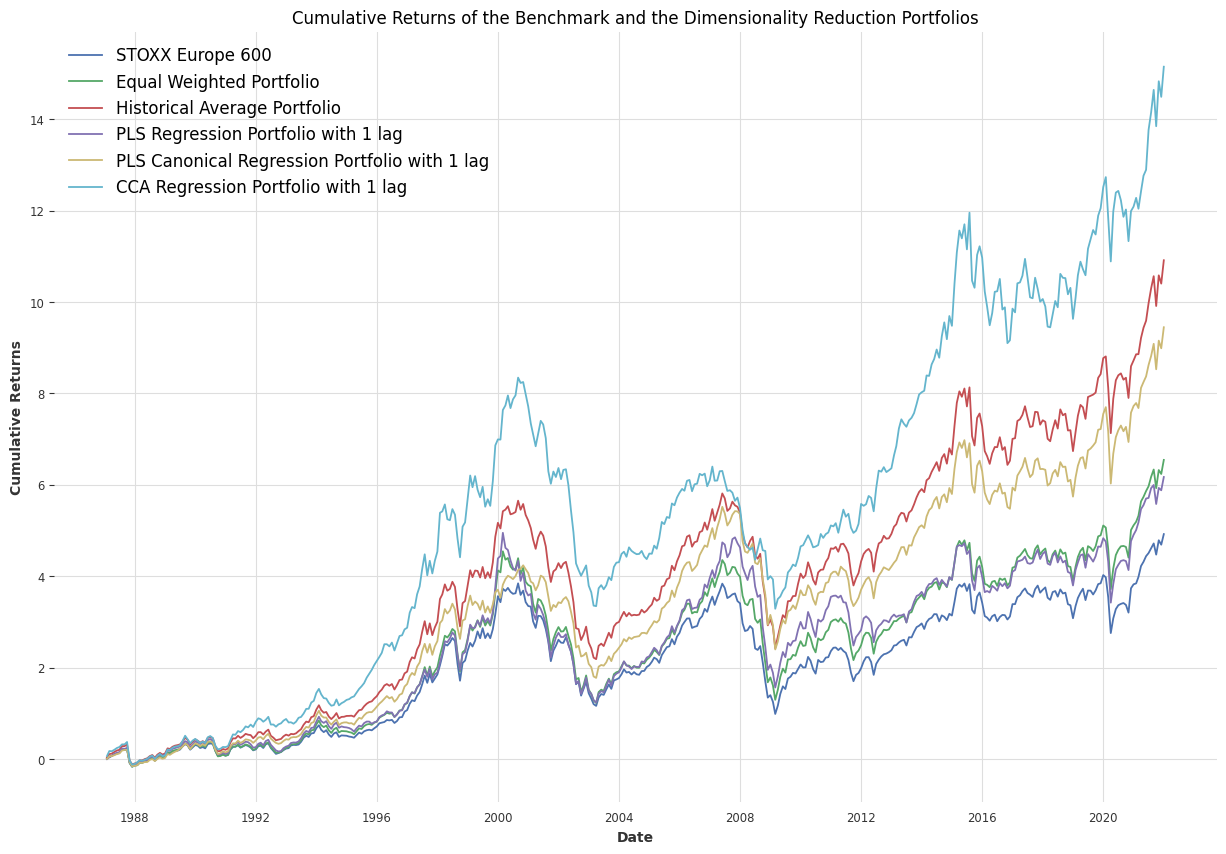

In [66]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['pls_regression_1'], label='PLS Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['canonical_pls_1'], label='PLS Canonical Regression Portfolio with 1 lag')
plt.plot(portfolio_returns['cca_regression_1'], label='CCA Regression Portfolio with 1 lag')
plt.legend(loc='upper left', fontsize=12)
plt.title('Cumulative Returns of the Benchmark and the Dimensionality Reduction Portfolios')
# set the x-axis label
plt.xlabel('Date')
# set the y-axis label
plt.ylabel('Cumulative Returns')
plt.show();

In [67]:
import tabulate

In [68]:
# create a dictionary with the portfolio returns
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted', 'Historical Average', 'PLS Regression', 'PLS Canonical Regression', 'CCA Regression'],
    '1 Lag': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0],
                portfolio_returns['equal_weighted'].tail(1).values[0],
                portfolio_returns['historical_average'].tail(1).values[0],
                portfolio_returns['pls_regression_1'].tail(1).values[0],
                portfolio_returns['canonical_pls_1'].tail(1).values[0],
                portfolio_returns['cca_regression_1'].tail(1).values[0]],
    '316 Lags': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0],
                 portfolio_returns['equal_weighted'].tail(1).values[0],
                    portfolio_returns['historical_average'].tail(1).values[0],
                    portfolio_returns['pls_regression_316'].tail(1).values[0],
                    None,
                    None]
}

In [69]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Divide the values by 100 to get the percentage
df[['1 Lag', '316 Lags']] = df[['1 Lag', '316 Lags']].div(100)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Format the DataFrame to display the values as percentages
df.style.format("{:.3%}", subset=['1 Lag', '316 Lags'])

,1 Lag,316 Lags
Portfolio,,
STOXX Europe 600,4.921%,4.921%
Equal Weighted,6.544%,6.544%
Historical Average,10.913%,10.913%
PLS Regression,6.170%,1.948%
PLS Canonical Regression,9.447%,nan%
CCA Regression,15.149%,nan%


In [70]:
# print this customized table to latex including the percentage sign and multiply the values by 100
print(df.to_latex(float_format="%.3f", formatters={"1 Lag": "{:.2%}".format, "316 Lags": "{:.2%}".format}))

\begin{tabular}{lrr}
\toprule
{} &  1 Lag & 316 Lags \\
Portfolio                &        &          \\
\midrule
STOXX Europe 600         &  4.92\% &    4.92\% \\
Equal Weighted           &  6.54\% &    6.54\% \\
Historical Average       & 10.91\% &   10.91\% \\
PLS Regression           &  6.17\% &    1.95\% \\
PLS Canonical Regression &  9.45\% &      NaN \\
CCA Regression           & 15.15\% &      NaN \\
\bottomrule
\end{tabular}



In [71]:
# convert portfolio returns as pandas.core.Series to a darts.TimeSeries
# save the portfolio returns as csv file
portfolio_returns.to_csv('data/portfolio_returns_dimred.csv', index=True, header=True)

# get portfolio returns from csv file as TimeSeries
portfolio_returns_timeseries = TimeSeries.from_csv('data/portfolio_returns_dimred.csv', index_col= 0, parse_dates=True)

In [81]:
# create a table that includes the mape, mse and r2score for each portfolio

data = {
    'Portfolio': ['PLS', 'PLS Canonical', 'CCA'],
    'MAPE': [mape(hf1_pls_regression, cum_returns),
             mape(hf1_canonical_pls, cum_returns),
             mape(hf1_cca, cum_returns)],
    'MSE': [mse(hf1_pls_regression, cum_returns),
            mse(hf1_canonical_pls, cum_returns),
            mse(hf1_cca, cum_returns)],
            'MAE': [mae(hf1_pls_regression, cum_returns),
                        mae(hf1_canonical_pls, cum_returns),
                        mae(hf1_cca, cum_returns)],
    'R2 Score': [r2_score(hf1_pls_regression, cum_returns),
                    r2_score(hf1_canonical_pls, cum_returns),
                    r2_score(hf1_cca, cum_returns)]
}

In [82]:
data

{'Portfolio': ['PLS', 'PLS Canonical', 'CCA'],
 'MAPE': [17.49149164331292, 8.294689186211349, 12.122059610530798],
 'MSE': [0.26433490903046075, 0.09718957462424306, 0.2157811974586605],
 'MAE': [0.31685062881567044, 0.20040811774530268, 0.29555049554740104],
 'R2 Score': [0.8464560820847239, 0.9194635623708229, 0.8688823250454665]}

In [86]:
# save data as dataframe in csv file
df = pd.DataFrame(data)
# set the index of the dataframe to be the portfolio column
df.set_index('Portfolio', inplace=True)
#format the dataframe to display the values as percentages
df.style.format("{:.3%}", subset=['MAPE', 'MSE', 'MAE', 'R2 Score'])
df.to_csv('data/evaluation_dimred.csv', index=True, header=True)

In [87]:
df

,MAPE,MSE,MAE,R2 Score
Portfolio,,,,
PLS,17.491492,0.264335,0.316851,0.846456
PLS Canonical,8.294689,0.097190,0.200408,0.919464
CCA,12.122060,0.215781,0.295550,0.868882


In [74]:
# create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# format the dataframe to display the values as percentages
df.style.format("{:.3%}", subset=['MAPE', 'MSE', 'R2 Score'])

# divide the values by 100 to get the percentage
df[['MAPE', 'MSE', 'R2 Score']] = df[['MAPE', 'MSE', 'R2 Score']].div(100)

# print this customized table to latex including the percentage sign
print(df.to_latex(float_format="%.3f", formatters={"MAPE": "{:.2%}".format, "MSE": "{:.2%}".format, "R2 Score": "{:.2%}".format}))

\begin{tabular}{lrrrr}
\toprule
{} &   MAPE &   MSE &   MAE & R2 Score \\
Portfolio     &        &       &       &          \\
\midrule
PLS           & 17.49\% & 0.26\% & 0.317 &    0.85\% \\
PLS Canonical &  8.29\% & 0.10\% & 0.200 &    0.92\% \\
CCA           & 12.12\% & 0.22\% & 0.296 &    0.87\% \\
\bottomrule
\end{tabular}



In [75]:
# save this table as csv file
df.to_csv('data/evaluation_dimred.csv', index=True, header=True)

In [76]:
# 
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted', 'Historical Average', 'PLS Regression', 'PLS Canonical Regression', 'CCA Regression'],
    'Return': [cum_returns_portfolio['STOXX Europe 600'].tail(1).values[0],
                portfolio_returns['equal_weighted'].tail(1).values[0],
                portfolio_returns['historical_average'].tail(1).values[0],
                portfolio_returns['pls_regression_1'].tail(1).values[0],
                portfolio_returns['canonical_pls_1'].tail(1).values[0],
                portfolio_returns['cca_regression_1'].tail(1).values[0]],
    'Volatility': [cum_returns_portfolio['STOXX Europe 600'].std(),
                portfolio_returns['equal_weighted'].std(),
                portfolio_returns['historical_average'].std(),
                portfolio_returns['pls_regression_1'].std(),
                portfolio_returns['canonical_pls_1'].std(),
                portfolio_returns['cca_regression_1'].std()]
}
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Divide the values by 100 to get the percentage
df[['Return', 'Volatility']] = df[['Return', 'Volatility']].div(100)

# Set the index of the DataFrame to be the Portfolio column
df.set_index('Portfolio', inplace=True)

# Format the DataFrame to display the values as percentages
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted,6.54%,1.63%
Historical Average,10.91%,2.67%
PLS Regression,6.17%,1.61%
PLS Canonical Regression,9.45%,2.32%
CCA Regression,15.15%,3.76%


In [77]:
print(df.to_latex(float_format="%.3f", formatters={"Return": "{:.2%}".format, "Volatility": "{:.2%}".format}))

\begin{tabular}{lrr}
\toprule
{} & Return & Volatility \\
Portfolio                &        &            \\
\midrule
STOXX Europe 600         &  4.92\% &      1.31\% \\
Equal Weighted           &  6.54\% &      1.63\% \\
Historical Average       & 10.91\% &      2.67\% \\
PLS Regression           &  6.17\% &      1.61\% \\
PLS Canonical Regression &  9.45\% &      2.32\% \\
CCA Regression           & 15.15\% &      3.76\% \\
\bottomrule
\end{tabular}



Weights:
                 STOXX Europe Banks  STOXX Europe Financials  STOXX Europe Auto & Parts  STOXX Europe Insurance  STOXX Europe Technology  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Basic Resource  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Inds Gds & Svs  STOXX Europe Media  STOXX Europe Telecoms     Sum
Max Sharpe                   0.28%                    1.47%                      5.02%                   0.90%                    7.05%                   1.36%                   2.18%                       -4.24%                  -1.46%                    55.16%                        7.56%              19.30%                  5.42% 100.00%
Min Volatility              16.00%                   18.12%                     16.39%                   1.62%                    2.40%                   0.93%                   0.00%                        0.00%                   5.76%                    14.78%                       17.74%             

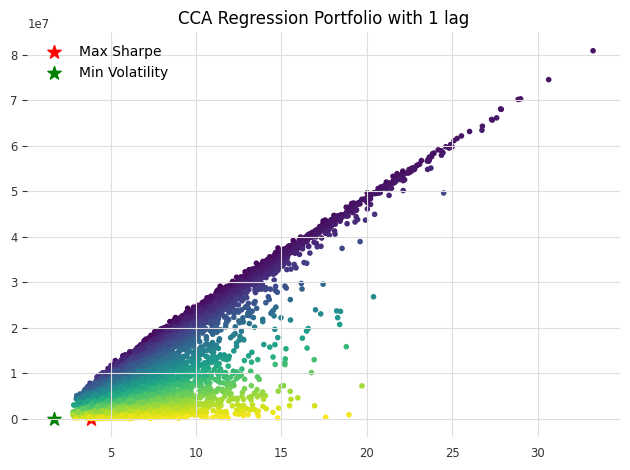

Weights:
                 STOXX Europe Banks  STOXX Europe Financials  STOXX Europe Auto & Parts  STOXX Europe Insurance  STOXX Europe Technology  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Basic Resource  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Inds Gds & Svs  STOXX Europe Media  STOXX Europe Telecoms     Sum
Max Sharpe                   0.27%                    1.57%                      6.40%                   0.90%                    7.02%                   1.36%                  -1.52%                       -1.57%                  -1.33%                    54.84%                        7.50%              19.18%                  5.38% 100.00%
Min Volatility              16.00%                   18.12%                     16.39%                   1.62%                    2.40%                   0.93%                   0.00%                        0.00%                   5.76%                    14.78%                       17.74%             

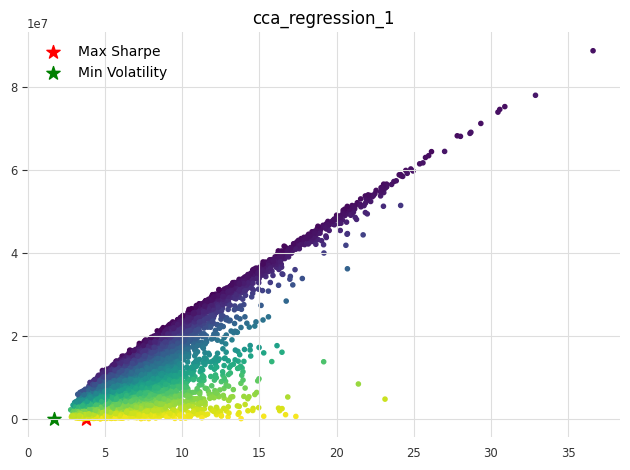

In [94]:
# plot efficient frontier for cca
plot_efficient_frontier(mu_cca_1, S_cca_1, cum_returns_portfolio, 'CCA Regression Portfolio with 1 lag')

In [93]:
# print the weights of cca
print('Weights for CCA regression with 1 lag: ' + str(np.round(pd.Series(weights_cca_1), 3)))

Weights for CCA regression with 1 lag: STOXX Europe 600               0.000
STOXX Europe Banks             0.003
STOXX Europe Financials        0.016
STOXX Europe Auto & Parts      0.064
STOXX Europe Insurance         0.009
STOXX Europe Technology        0.070
STOXX Europe Utilities         0.014
STOXX Europe Chemicals        -0.015
STOXX Europe Basic Resource   -0.016
STOXX Europe Con & Mat        -0.013
STOXX Europe Health Care       0.548
STOXX Europe Inds Gds & Svs    0.075
STOXX Europe Media             0.192
STOXX Europe Telecoms          0.054
dtype: float64
